In [1]:
%load_ext autoreload
%autoreload

In [1]:
import os
import torch
import numpy as np
import polars as pl
from model_vae import *
from data_preparation import *
from plotting import *
from postprocess import *

In [31]:
def visualize_dimensions_as_points(model, metadata, reference_candidates=None, plot_reference=True,
                                  output_file=None, contest_filter=None, 
                                  dim_labels=None, figsize=(15, 10)):
    """
    Visualize each dimension separately as points, with contests on y-axis and values on x-axis.
    
    Parameters:
    -----------
    adjusted_params : list
        List of adjusted discrimination parameter tensors
    reference_info : dict
        Information about reference candidates
    metadata : dict
        Dictionary containing mappings between races/candidates and indices
    output_file : str, optional
        Path to save the visualization
    contest_filter : str, optional
        Only include contests containing this string
    dim_labels : list, optional
        Labels for each dimension (default: ["Liberal-Conservative", "Dimension 2", ...])
    figsize : tuple, optional
        Figure size (width, height)
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    adjusted_params, reference_info = postprocess_discrimination_parameters(
        model, metadata, reference_candidates
    )

    # Determine number of dimensions from the first non-empty tensor
    for params in adjusted_params:
        if params.size(0) > 0:
            n_dims = params.size(1)
            break
    else:
        raise ValueError("No non-empty parameter tensors found")
    
    # Create default dimension labels if not provided
    if dim_labels is None:
        dim_labels = ["Liberal-Conservative" if i == 0 else f"Dimension {i+1}" for i in range(n_dims)]
    
    # Create figure with subplots (one per dimension)
    fig, axes = plt.subplots(1, n_dims, figsize=figsize, sharey=True)
    if n_dims == 1:
        axes = [axes]  # Handle single dimension case
    
    # Collect all contests and candidates to determine y-axis ordering
    contest_candidates = []
    
    for contest_idx, contest_params in enumerate(adjusted_params):
        # Get contest info
        race_name = reference_info[contest_idx]['race']
        
        # Skip if contest_filter is provided and not in race_name
        if contest_filter is not None and contest_filter not in race_name:
            continue
        
        # Extract office and district
        parts = race_name.split('_')
        office = parts[0]
        district = parts[1] if len(parts) > 1 else ""
        
        # Get candidate names
        candidate_map = metadata['candidate_maps'][contest_idx]
        
        # Add each candidate
        for candidate_idx, candidate_name in sorted([(v, k) for k, v in candidate_map.items()]):
            if not plot_reference and candidate_idx == reference_info[contest_idx]['index']:
                continue
            
            label = f"{office}-{district}: {candidate_name}"
            contest_candidates.append((contest_idx, candidate_idx, label))
    
    # Sort contest candidates by office, district, name for consistent ordering
    contest_candidates.sort(key=lambda x: x[2])
    
    # Create reversed mapping for y-positions
    y_positions = {candidate_tuple: i for i, candidate_tuple in enumerate(contest_candidates)}
    
    # Define color map for different contests
    contest_colors = plt.cm.tab10.colors
    
    # Plot each dimension
    for dim_idx in range(n_dims):
        ax = axes[dim_idx]
        
        # Set dimension title
        ax.set_title(dim_labels[dim_idx], fontsize=12)
        
        # Plot points for each contest/candidate
        for contest_idx, candidate_idx, label in contest_candidates:
            # Get parameter value for this dimension
            if candidate_idx == reference_info[contest_idx]['index']:
                value = 0
            else:
                value = adjusted_params[contest_idx][candidate_idx, dim_idx].item()
            
            # Get y-position
            y_pos = y_positions[(contest_idx, candidate_idx, label)]
            
            # Get color based on contest
            color = contest_colors[contest_idx % len(contest_colors)]
            
            # Plot point
            ax.scatter(value, y_pos, color=color, s=50)
            
            # Add candidate label on the first dimension plot only
            if dim_idx == 0:
                ax.text(-0.1, y_pos, label, fontsize=8, ha='right', va='center')
        
        # Add vertical line at zero
        ax.axvline(x=0, color='black', linestyle='--', alpha=0.3)
        
        # Set x-axis label
        ax.set_xlabel(f"Value", fontsize=10)
        
        # Remove y-axis ticks except for first plot
        if dim_idx > 0:
            ax.set_yticklabels([])
        else:
            ax.set_yticks([])  # No y-axis ticks for first plot either since we have text labels
    
    # Set common y-axis label
    fig.text(0.01, 0.5, 'Contests & Candidates', fontsize=12, va='center', rotation='vertical')
    
    # Add overall title
    plt.suptitle('Discrimination Parameters by Dimension', fontsize=14)
    
    # Adjust layout
    plt.tight_layout(rect=[0.05, 0, 1, 0.95])  # Make room for y-axis label
    
    # Adjust horizontal spacing between subplots
    plt.subplots_adjust(wspace=0.05)
    
    # Save or display
    if output_file:
        plt.savefig(output_file, dpi=300, bbox_inches='tight')
        print(f"Visualization saved to {output_file}")
    
    return output_file

## Data Prep

In [3]:
final_data = pl.read_parquet("data/colorado_prepared.parquet")

## Model Setup

In [4]:
# Prepare data for the VAE model
save_dir = "intermediates"
load_data = True
save_data = False

if load_data:
    input_data, target_indices, participation_mask_tensor, num_candidates_per_contest, metadata = load_prepared_data(save_dir)
else:
    input_data, target_indices, participation_mask_tensor, num_candidates_per_contest, metadata = load_and_prepare_voter_data(final_data)
    
    if save_data: save_prepared_data(save_dir, (input_data, target_indices, participation_mask_tensor, num_candidates_per_contest, metadata))


# Create and train the model
# Model parameters
hidden_dim = 64
latent_dim = 2
num_epochs = 30
batch_size = 256
learning_rate = 1e-3

pres_race_name = "US PRESIDENT_FEDERAL"
trump_name = "DONALD J TRUMP"
biden_name = "JOSEPH R BIDEN"

model = VoterChoiceVAE(
    num_contests=len(num_candidates_per_contest),
    num_candidates_per_contest=num_candidates_per_contest,
    hidden_dim=hidden_dim,
    latent_dim=latent_dim
)
model = model.to(get_device())

In [ ]:
# Train with constraint
soft_model = train_voter_vae_constrained(
    model, 
    input_data, 
    target_indices,
    participation_mask_tensor,
    metadata, 
    pres_race_name, 
    trump_name, 
    biden_name,
    num_epochs=num_epochs,
    batch_size=batch_size,
    learning_rate=learning_rate,
    kl_start_weight=0,
    kl_end_weight=0.5,
    kl_annealing='sigmoid',
    constraint_weight=1
)

# Apply post-processing to ensure consistent orientation of all latent dimensions
soft_model = post_process_latent_space(soft_model, metadata, pres_race_name, trump_name, biden_name)

In [5]:
# Save only the model parameters

load_model = True

if load_model:
    model.load_state_dict(torch.load('models/vae_sample2000_noCollapse.pt', weights_only=True, map_location=torch.device('cpu')))
else:
    torch.save(soft_model.state_dict(), 'models/vae_adams.pt')


In [ ]:
# Generate and analyze embeddings
print("\nGenerating voter embeddings...")
# voter_embeddings_df = analyze_voter_embeddings(model, input_data, participation_mask_tensor, metadata)

# Extract IRT parameters
print("\nExtracting IRT-equivalent parameters...")
discrimination_params, difficulty_params = model.get_irt_parameters()

# Convert to more interpretable format
print("\nSample of discrimination parameters for the president:")
first_contest = list(metadata['race_to_idx'].keys())[-2]
first_contest_idx = metadata['race_to_idx'][first_contest]
first_contest_discrimination = discrimination_params[first_contest_idx].numpy()

print(f"Contest: {first_contest}")
for i, candidate in enumerate(metadata['candidate_maps'][first_contest_idx].keys()):
    print(f"  Candidate: {candidate}")
    print(f"    Discrimination parameters: {first_contest_discrimination[i]}")

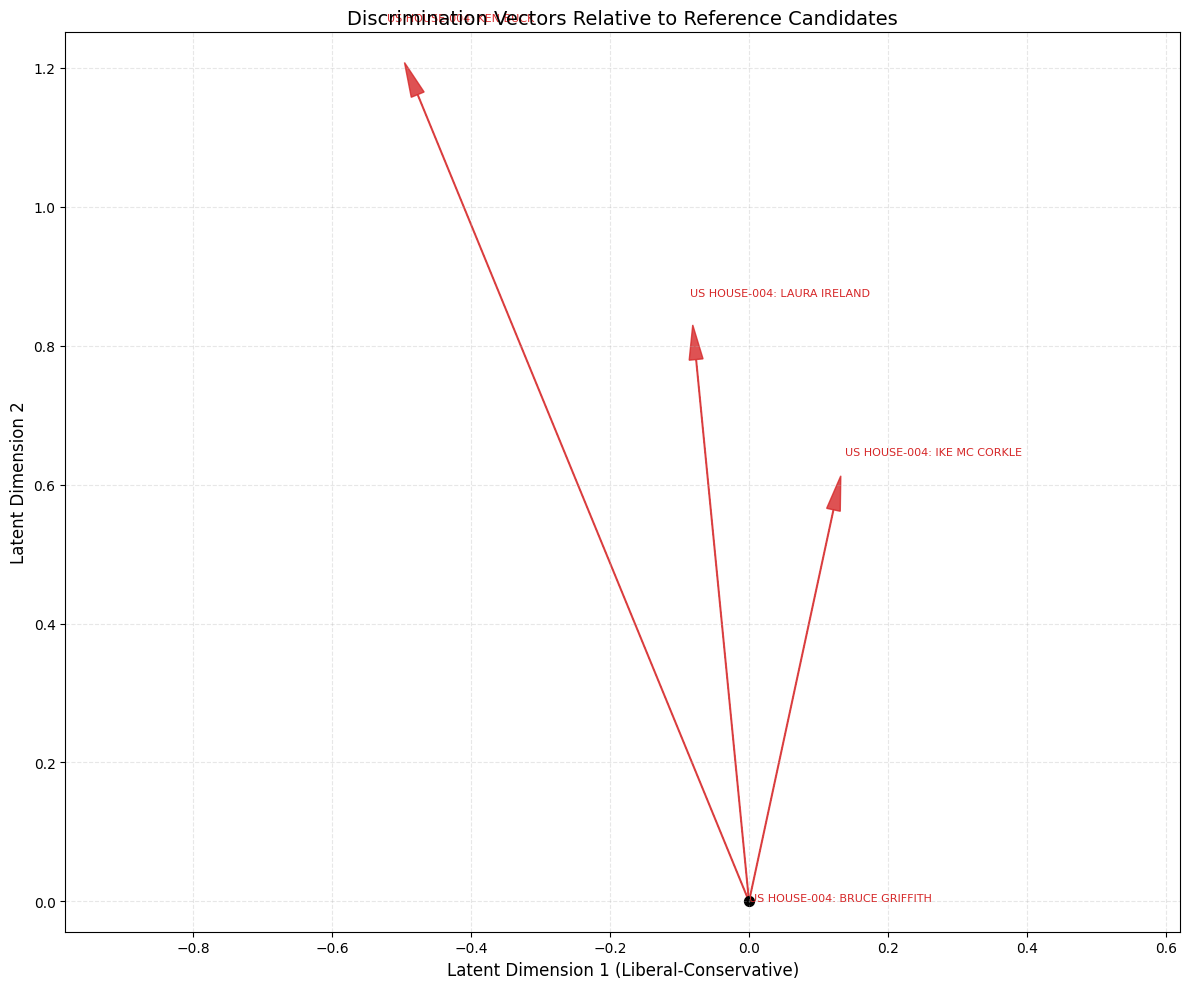

<Figure size 640x480 with 0 Axes>

In [21]:
office_idx = metadata["race_to_idx"]["US PRESIDENT_FEDERAL"]
biden_idx = metadata["candidate_maps"][office_idx]["JOSEPH R BIDEN"]

# Now apply reference candidate post-processing for visualization
adjusted_params, reference_info = process_and_visualize_relative_vectors(
    model, input_data, participation_mask_tensor, metadata, final_data, 
    contest_filter = "US HOUSE_004",
    # reference_candidates = {office_idx: biden_idx}, contest_filter = ["US PRESIDENT"]
)

In [ ]:
visualize_voter_latent_space(
    model, input_data, participation_mask_tensor, 
    metadata, final_data, pres_race_name, trump_name, biden_name
)

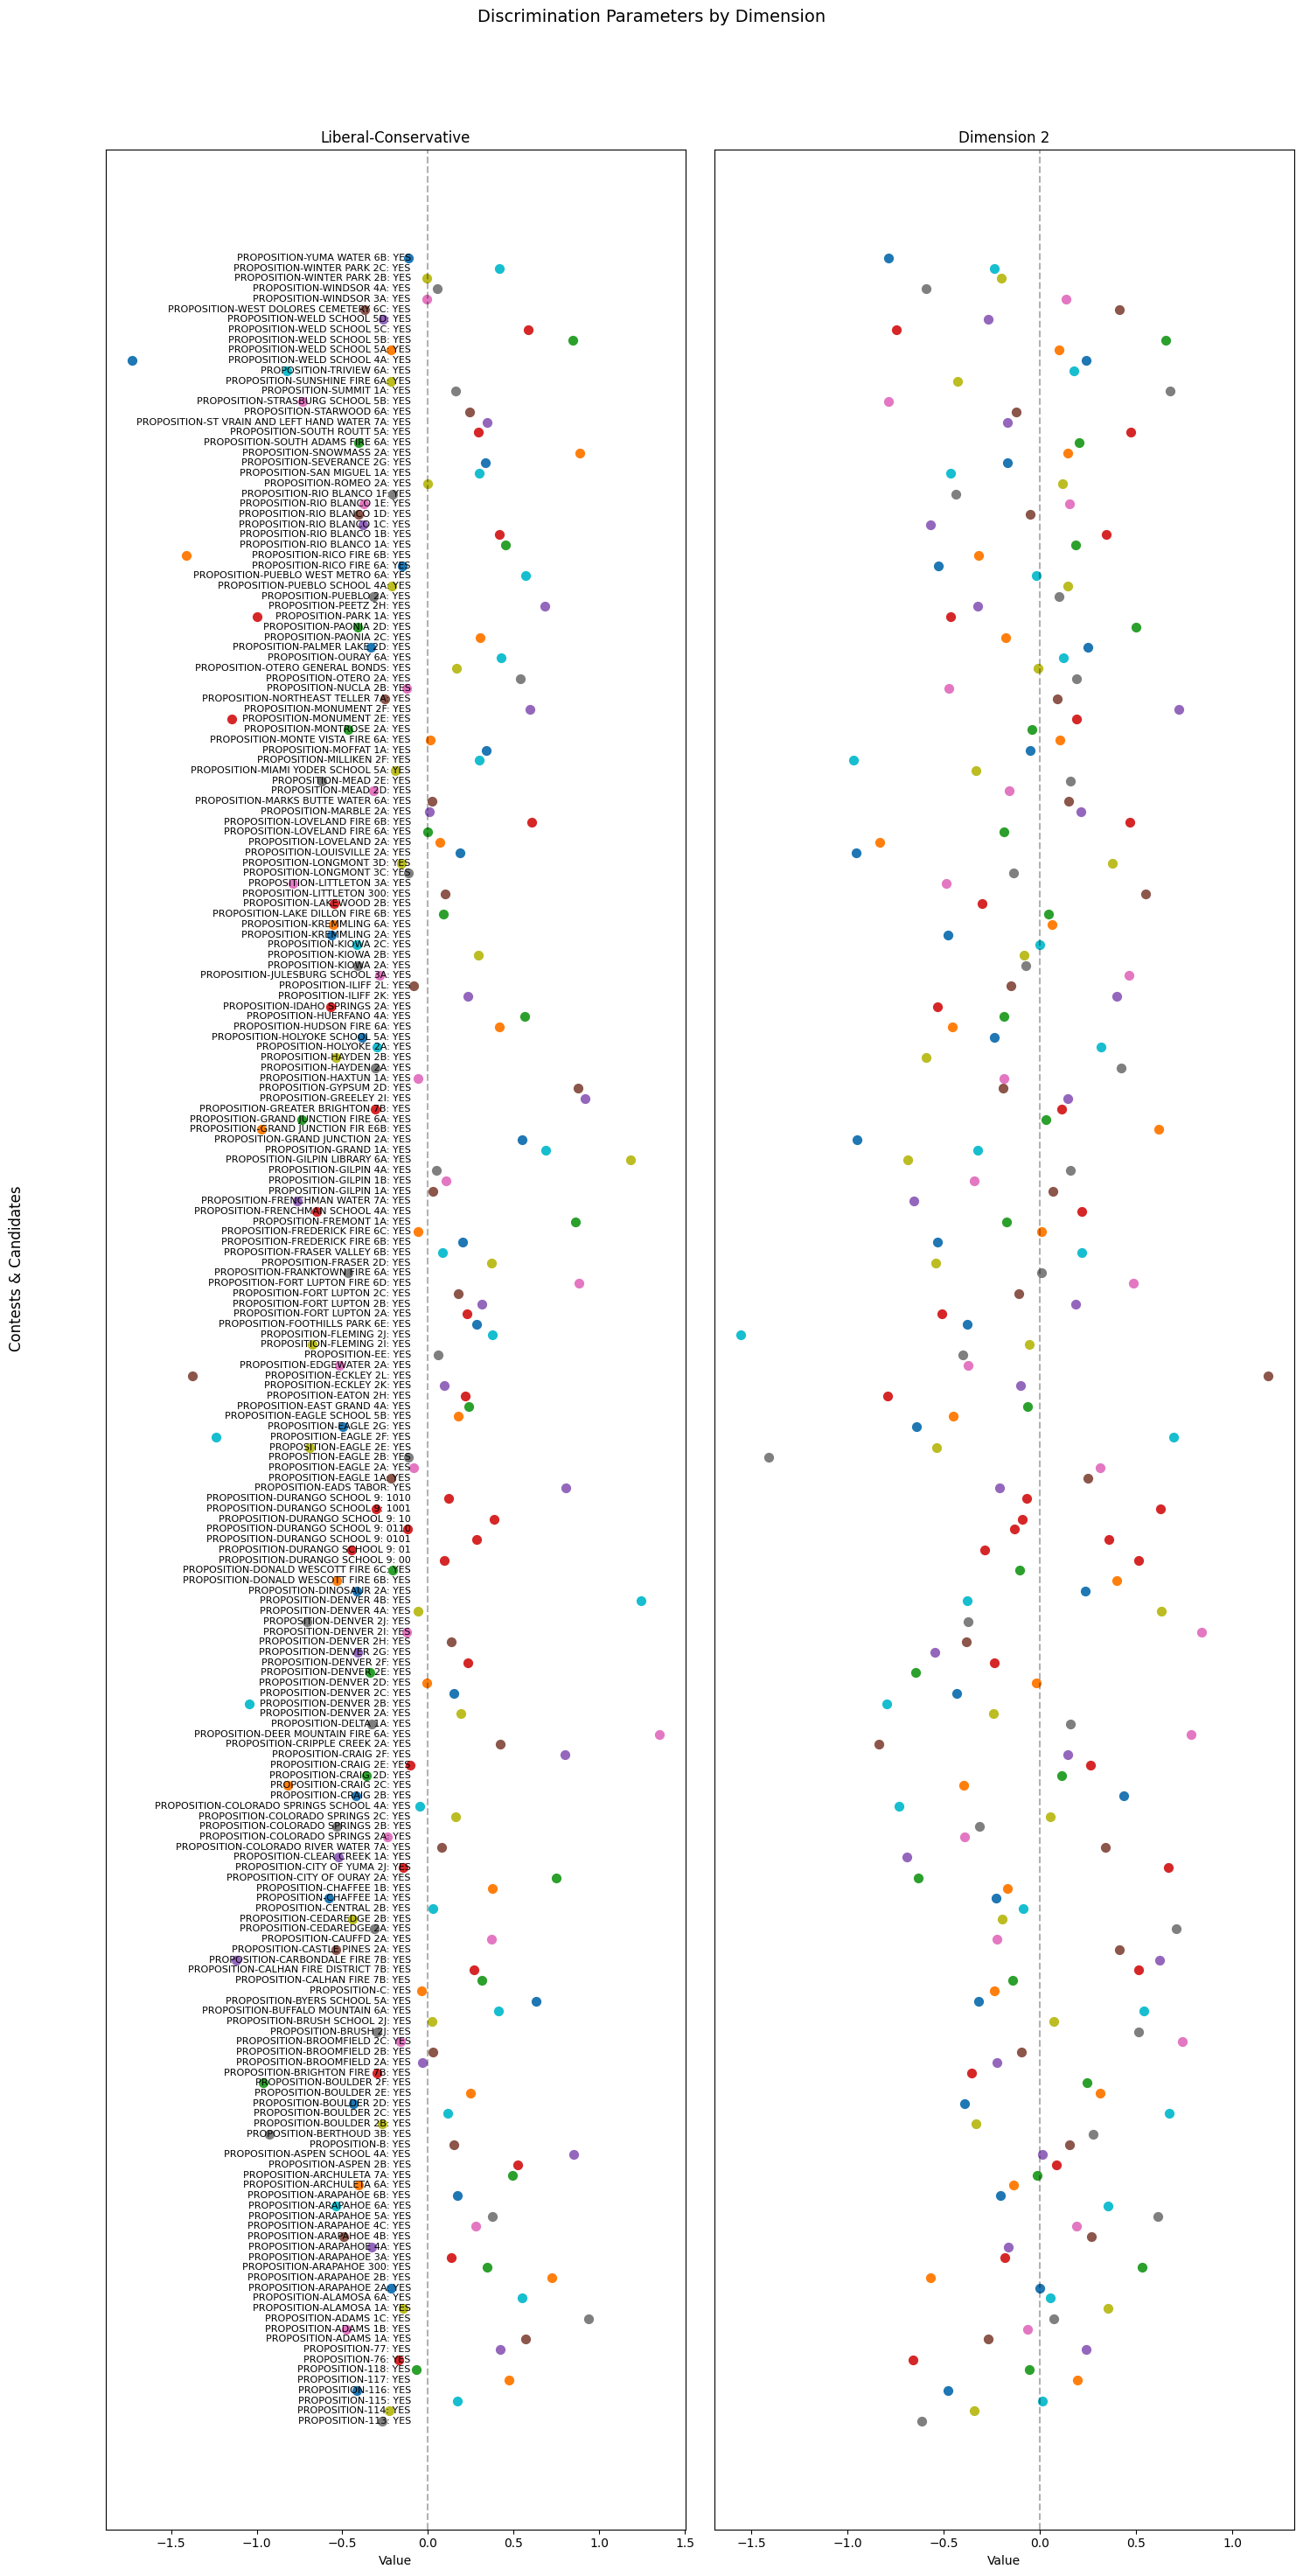

In [32]:
office_idx = metadata["race_to_idx"]["US SENATE_COLORADO"]
candidate_idx = metadata["candidate_maps"][office_idx]["JOHN W HICKENLOOPER"]

visualize_dimensions_as_points(
        model, 
        metadata,
        reference_candidates = {office_idx: candidate_idx},
        contest_filter="PROPOSITION",
        plot_reference=False,
        figsize=(15, 30),
    )

## Archive

In [ ]:
create_latent_space_visualizations(
    soft_model, input_data, participation_mask_tensor, metadata,
    final_data, num_candidates_per_contest, pres_race_name, trump_name, biden_name
)

In [ ]:
# base_data_pl = pl.read_parquet("../cvrs/data/pass2/state=COLORADO/county_name=ADAMS/", columns = ["state", "county_name", "cvr_id", "candidate", "district", "magnitude", "office", "party_detailed"])

base = pl.scan_parquet("../cvrs/data/pass2/state=COLORADO").with_columns((pl.col('office') + '_' + pl.col('district')).alias('race'))

data_subset = pl.scan_parquet("adams_subset.parquet").with_columns(pl.lit("ADAMS").alias('county_name'))

# drop uncontested elections
small_candidates = (base
    .filter(pl.col("candidate") != "UNDERVOTE")
    .group_by(['race', 'candidate'])
    .agg(pl.len().alias('n'))
    .filter(pl.col('n') <= 20)
    .select(['race', 'candidate'])
    .unique())

# Equivalent of anti_join and subsequent operations
contested_races = (base
    .filter(pl.col("candidate") != "UNDERVOTE")
    # Anti-join equivalent: keep only rows where (race, candidate) is not in small_candidates
    .join(small_candidates, on=['race', 'candidate'], how='anti')
    .select(['race', 'candidate'])
    .unique()
    .group_by('race')
    .agg(pl.len().alias('n'))
    .filter(pl.col('n') > 1)
    .select('race'))

# Rejoin with original data to get all records for these individuals
final_data = (
    base
    .with_columns(pl.col('cvr_id').cast(pl.Utf8))
    .join(
        contested_races,
        on=['race'],
        how="inner"
    )
    .join(
        data_subset.select(['county_name', "cvr_id"]),
        on=["county_name", "cvr_id"],
        how="inner"
    )
    .select(
        ["county_name", "cvr_id", "office", "district", "candidate"]
     )
    .filter(
        pl.col("candidate") != "UNDERVOTE"
    )
    .collect()
    .to_pandas()
)

final_data